In [1]:
import pickle
import numpy as np
import torch
import os
import pandas as pd
import tkinter as tk

from tqdm import tqdm, tqdm_notebook
from PIL import Image as PILImage
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from tkinter import *
from tkinter import ttk
from tkinter import Tk
from tkinter import filedialog as fd
from tkinter import messagebox as mb

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
def callback():
    names = fd.askopenfilenames() 
    #print(name)
    with open('temp_swans.txt', 'w', newline = '') as file:
        file.write(str(names))
    mb.showinfo('Отправлено', 'Файлы поступили в обработку. Пожалуйста, закройте программу и немного подождите.\n\nРезультат будет находиться в файле "Swans result.csv" в папке с этой программой.\n\nВероятность точного попадания на примере нескольких картинок сохраняется в "Probabilities.png"')
    
errmsg = 'Error!'
window = Tk()
window.title("Defining swans")
window.geometry('1920x1080')

frame = Frame (window)
frame.place(relwidth = 1, relheight = 1)

title0 = Label(frame, text = 'Перед началом работы убедитесь, что файл Swans.h5 лежит в директории C:/Swans', font = 16, height = 2, fg = '#F00')
title0.pack()
title1 = Label(frame, text = 'Нажмите на кнопку, чтобы добавить фото, которые хотите обработать', font = 16, height = 2)
title1.pack()
title2 = Label(frame, text = 'Если Вы хотите выбрать все файлы из папки, нажмите на любой из них и зажмите Ctrl+A', font = 16, height = 2)
title2.pack()
btn = Button(frame, text = 'Добавить фото', font = 4, command = callback, bg = '#F4A460', height = 2, width = 100)
btn.pack(fill = tk.X)

tk.mainloop()

In [3]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

label_encoder = LabelEncoder()

In [4]:
class Dataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = PILImage.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
class Cnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [7]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs
        labels = labels

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [8]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs
            model.eval()
            outputs = model(inputs)
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
def predict_one_sample(model1, inputs):
    with torch.no_grad():
        inputs = inputs
        model1.eval()
        logit = model1(inputs)
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [10]:
test_files = []

In [11]:
with open('temp_swans.txt', 'r') as file:
    text = file.read()
    files = text.split("\', \'")
    for i in files:
        test_files.append(i.replace("'","").replace("(","").replace(")","").replace(",",""))

In [12]:
test_dataset = Dataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=10)

In [13]:
model = Cnn(3)
model.load_state_dict(torch.load('C:/Swans/Swans.h5'))
model.eval()
labels = ['klikun', 'shipun', 'malij']
label_encoder.fit(labels)
labels = label_encoder.transform(labels)
prediction = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(prediction, axis=1))
result = []
for i in preds:
    if i == 'shipun':
        result.append(3)
    if i == 'klikun':
        result.append(2)
    if i == 'malij':
        result.append(1)

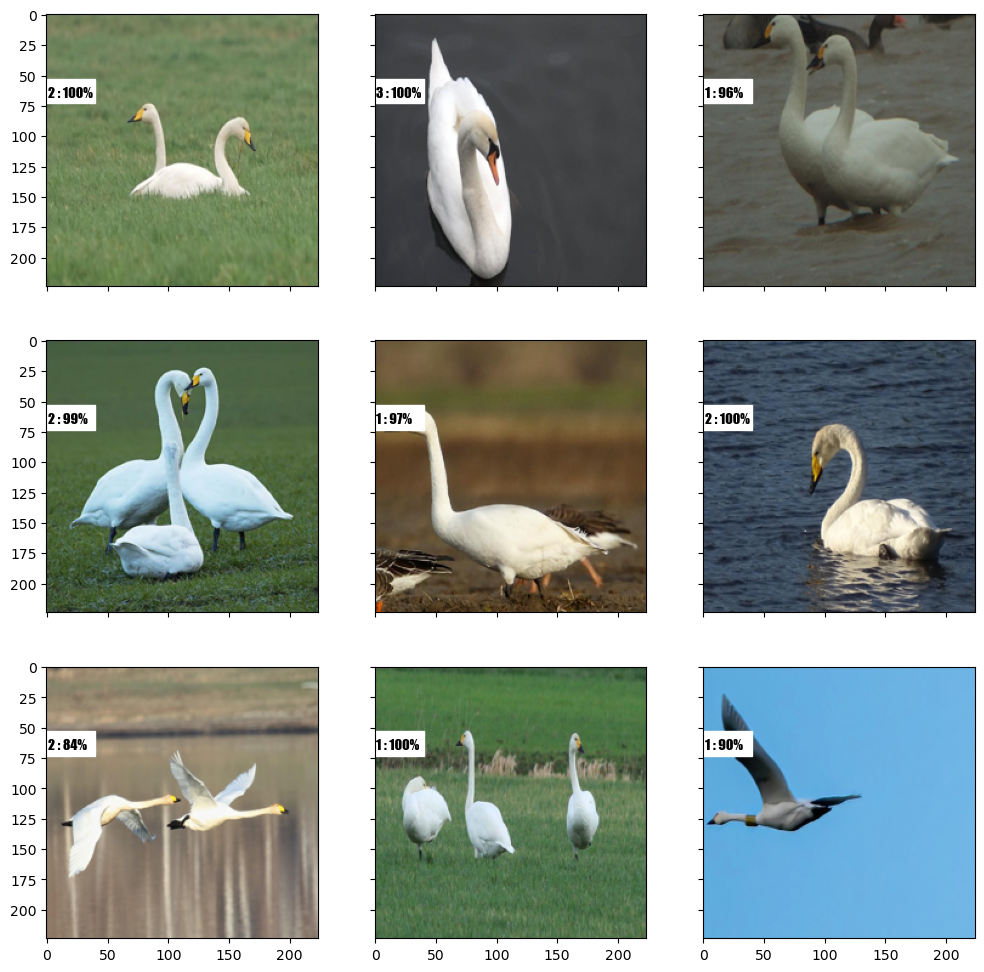

In [14]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(test_files)))
    im_test = test_dataset[random_characters]
    imshow(im_test.data.cpu(),plt_ax=fig_x)
            
    fig_x.add_patch(patches.Rectangle((0, 53),40,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_test.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    if predicted_label=='shipun':
        predicted_label=3
    if predicted_label=='klikun':
        predicted_label=2
    if predicted_label=='malij':
        predicted_label=1
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black')
plt.plot()
plt.savefig('Probabilities.png')

In [15]:
my_submit = pd.DataFrame({'name': [os.path.basename(i) for i in test_files], 'class': result})
my_submit.to_csv('Swans result.csv', index=False)
read = pd.read_csv('Swans result.csv')
read

,name,class
0,0.jpg,3
1,1.jpg,1
2,2.jpg,1
3,3.jpg,2
4,4.jpg,1
...,...,...
590,590.jpg,2
591,591.jpg,1
592,592.jpg,3
593,593.jpg,2


In [16]:
os.remove('temp_swans.txt')